# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = LightGreen > **Assignment 2: Discrete-Event Simulation** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

## <font color = LightBlue> **Exercise 1** </font>

#### <font color = Grey> ***MATHEMATICAL EXPLANATION*** </font>
Queing theory is applicable to many real-world scenario's. By looking at $\textit{performance measures}$, such as mean waiting time and the mean number of customers in a system, we can derive some characteristics about the system. We will be looking at the mean waiting time of two different types of queing, namely M/M/1 and M/M/c, with a closer look at M/M/2. Hence we will compare queing with one server and 2 servers respectively. In order to evaluate the mean waiting time for these two types, we need to establish some parameters:

- $E(S)$ = Mean sojourn time (waiting in queue + service time)
- $E(L)$ = Mean number of customers in the system
- $\lambda$ = Rate of arrivals
- $\mu$ = Rate of service
- $\rho$ = $\frac{\lambda}{\mu}$ (server utilization/load)
- $E(L)$ = $\lambda$ $\cdot$ $E(S)$ (Little's Law)

##### <font color = Green> ***M/M/1*** </font>
In a M/M/1 system the mean number of customers in the systems is defined as: </br>

$ E(L) = \sum_{n=0}^{\infty} n \cdot p_n = \frac{\rho}{1- \rho} $

This can be rewritten as:</br>
$ E(L) = \frac{\lambda}{\mu- \lambda} $

$ E(L)$ cannot be negative as we cannot have negative queues, therefore the condition $\lambda<\mu$ holds. This gives $\rho=\frac{\lambda}{\rho}<1$

In order to find the mean number of customers in the queue $(E(L^q))$, the mean number of customers in service need to substracted from $E(L)$: </br>
$ E(L^q) = E(L) - \rho = \frac{\rho^2}{1- \rho} $. 

Finally, by applying Little's Law, we obtain the mean waiting time: </br>
$E(W) = \frac{\rho}{\mu} \cdot \frac{1}{1-\rho}$

##### <font color = Green> ***M/M/c*** </font>
The mean number of customers in the queue is given by: </br>
$ E(L^q) = \sum_{n=0}^{\infty} n \cdot p_{c+n} $ </br>
$        = \frac{p_c}{1 - \rho} \cdot \sum_{n=0}^{\infty} n \cdot (1- \rho) \cdot \rho^n $ </br>
$        = \pi_W \cdot \frac{\rho}{1 - \rho} $

By applying Little's Law, we obtain the mean waiting time: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{c \cdot \mu} $,
in case of two servers, this would yield in: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2 \cdot \mu} $


#### <font color = Grey> ***THEORETICAL EXPLANATION***</font>
In a queuing system where multiple servers are available (M/M/n), each server shares the task of handling incoming customers, as opposed to all customers lining up for a single server (M/M/1). This setup reduces the effective arrival rate of customers to each server because they are distributed across several servers. As a result, customers are likely to wait less because there is a higher chance that one of the servers will be free to help them sooner. Therefore, the system can manage more customer arrivals. This efficiency becomes especially significant when the system is close to its maximum capacity, denoted by a utilization value ($\rho$) near 1. At this point, the presence of multiple servers is more important, as they collectively handle the high volume of customers and keep wait times shorter than what a single server could achieve.

When $\rho$ is significantly less than one, the system is underutilized. There is ample service capacity to handle the arriving customers, so customers rarely have to wait, and the queue is often empty or very short. This does not provide much insight into the behavior of the queue under stress. However, when $\rho$ is close to one, without exceeding it, the system is operating near its maximum capacity. This scenario is much more interesting because it tests the limits of the ability of the system to handle utilisation. Small fluctuations in arrival or service rates can cause significant changes in wait times and queue lengths.

## <font color = LightBlue> **Exercise 2** </font>

In [ ]:
import simpy
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Parameters
RANDOM_SEED = 42
SIM_TIME = 300
NUM_SERVERS = [1, 2, 4]
ARRIVAL_RATES = np.linspace(5, 13, 10)  # Different arrival rates to experiment with
SERVICE_RATES = [8, 10, 12]  # Different service rates to experiment with
NUM_RUNS = 15

random.seed(RANDOM_SEED)

# Modified service time function to accept dynamic service rates
def get_service_time(service_rate, service_type):
    if service_type == "M":
        return random.expovariate(service_rate)
    elif service_type == "D":
        return 1 / service_rate  # Deterministic service time
    # Add other types if needed

# Customer process
def customer(env, servers, wait_times_list, service_rate, service_type):
    arrival_time = env.now
    with servers.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times_list.append(wait_time)
        service_time = get_service_time(service_rate, service_type)
        yield env.timeout(service_time)

# Source process
def source(env, num_servers, arrival_rate, service_rate, servers, wait_times_list, service_type):
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, servers, wait_times_list, service_rate, service_type))

# Simulation setup
def run_simulation(num_servers, arrival_rate, service_rate, wait_times_list, service_type):
    env = simpy.Environment()
    servers = simpy.Resource(env, capacity=num_servers)
    env.process(source(env, num_servers, arrival_rate, service_rate, servers, wait_times_list, service_type))
    env.run(until=SIM_TIME)


# Data aggregation
def aggregate_data(times_list):
    mean_time = statistics.mean(times_list)
    stdev_time = statistics.stdev(times_list)
    ci_low, ci_upp = scipy.stats.t.interval(0.95, len(times_list)-1, loc=mean_time, scale=stdev_time/np.sqrt(len(times_list)))
    return mean_time, ci_low, ci_upp

# Main simulation function
def main(num_servers, arrival_rates, service_rates, service_type):
    results = []
    for n_servers in num_servers:
        for lambd in arrival_rates:
            for mu in service_rates:
                # This will store the mean wait time for each run
                run_means = []

                for _ in range(NUM_RUNS):
                    run_wait_times = []
                    run_simulation(n_servers, lambd, mu, run_wait_times, service_type)
                    run_means.append(statistics.mean(run_wait_times))

                # Calculate the mean of the run means and the CI across these run means
                overall_mean_wait = statistics.mean(run_means)
                stdev_wait = statistics.stdev(run_means)
                ci_low_wait, ci_upp_wait = scipy.stats.t.interval(0.95, len(run_means)-1, loc=overall_mean_wait, scale=stdev_wait/np.sqrt(len(run_means)))
                results.append((n_servers, lambd, mu, overall_mean_wait, ci_low_wait, ci_upp_wait))
                print(f'Num servers: {n_servers}, Arrival rate: {lambd}, Service rate: {mu}, Mean wait: {overall_mean_wait:.2f}, 95% CI: ({ci_low_wait:.2f}, {ci_upp_wait:.2f})')
    return results



def plot_results(results):
    # Prepare the data for plotting
    plot_data = {}
    for n_servers, lambd, mu, mean_wait, ci_low_wait, ci_upp_wait in results:
        if mu not in plot_data:
            plot_data[mu] = {n: [] for n in NUM_SERVERS}
        plot_data[mu][n_servers].append((lambd, mean_wait, ci_low_wait, ci_upp_wait))

    # Plot the results
    plt.figure(figsize=(16, 8), dpi=300)
    markers = ['o', 's', '^']  # Different markers for different number of servers
    colors = plt.cm.viridis(np.linspace(0, 1, len(SERVICE_RATES)))  # Get a colormap range based on the number of service rates

    for i, (mu, server_data) in enumerate(plot_data.items()):
        for n_servers, data in server_data.items():
            data.sort()  # Sort the data by arrival rate
            lambdas, mean_waits, ci_lows, ci_upps = zip(*data)
            plt.plot(lambdas, mean_waits, color=colors[i], marker=markers[NUM_SERVERS.index(n_servers)],
                     label=f'Service Rate μ={mu}, Servers n={n_servers}')

            # Add diffuse pattern for confidence intervals
            plt.fill_between(lambdas, ci_lows, ci_upps, color=colors[i], alpha=0.2)

    plt.xlabel('Arrival Rate (λ)', fontsize=18, fontweight='bold')
    plt.ylabel('Mean Waiting Time', fontsize=18, fontweight='bold')
    plt.title('Mean Waiting Time for Different Number of Servers and Varying Arrival and Service Rates', fontsize=20, fontweight='bold')
    plt.legend(loc='upper left', prop={"size":14})
    plt.grid(True)
    plt.show()


# Plotting
results = main(NUM_SERVERS, ARRIVAL_RATES, SERVICE_RATES, "M")

plot_results(results)

In [ ]:
import simpy
import random
import statistics
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Parameters
RANDOM_SEED = 42
SIM_TIME = 300
MU = 10
NUM_SERVERS = [1, 2, 4]
RHO_VALUES = np.linspace(0.92, 0.99, 8)
NUM_RUNS = 15

random.seed(RANDOM_SEED)

# Service time functions
def get_service_time(service_type):
    if service_type == "M":
        return random.expovariate(MU)
    elif service_type == "D":
        return 1 / MU  # Deterministic service time
    elif service_type == "H":
        return hyperexponential_service_time()
    else:
        raise ValueError("Invalid service type")

# Function for hyperexponential function (long-tail?)
def hyperexponential_service_time():
    distribution_choice = random.choices([1.0, 5.0], weights=[0.75, 0.25])[0]
    rate = 1.0 / distribution_choice
    return random.expovariate(rate)

# Customer process
def customer(env, servers, wait_times_list, sojourn_times_list, service_type):
    arrival_time = env.now
    with servers.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times_list.append(wait_time)
        service_time = get_service_time(service_type)
        yield env.timeout(service_time)
        sojourn_time = env.now - arrival_time
        sojourn_times_list.append(sojourn_time)

# Source process
def source(env, num_servers, rho, servers, wait_times_list, sojourn_times_list, service_type):
    arrival_rate = rho * num_servers * MU
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, servers, wait_times_list, sojourn_times_list, service_type))

# Simulation setup
def run_simulation(num_servers, rho, wait_times, sojourn_times, priority, service_type):
    env = simpy.Environment()
    servers = simpy.PriorityResource(env, capacity=num_servers) if priority else simpy.Resource(env, capacity=num_servers)
    wait_times_list = wait_times[num_servers][rho]
    sojourn_times_list = sojourn_times[num_servers][rho]
    env.process(source(env, num_servers, rho, servers, wait_times_list, sojourn_times_list, service_type))
    env.run(until=SIM_TIME)

# Data aggregation and analysis
def aggregate_data(times_list):
    mean_time = statistics.mean(times_list)
    stdev_time = statistics.stdev(times_list)
    ci_low, ci_upp = scipy.stats.t.interval(0.95, len(times_list)-1, loc=mean_time, scale=stdev_time/np.sqrt(len(times_list)))
    return mean_time, ci_low, ci_upp

# Main simulation function
def main(num_servers, rho_values, priority, service_type):
    results = []
    wait_times = {n: {rho: [] for rho in rho_values} for n in num_servers}
    sojourn_times = {n: {rho: [] for rho in rho_values} for n in num_servers}
    # Store mean wait times and sojourn times per run
    run_mean_wait_times = {n: {rho: [] for rho in rho_values} for n in num_servers}
    run_mean_sojourn_times = {n: {rho: [] for rho in rho_values} for n in num_servers}

    for n_servers in num_servers:
        for rho in rho_values:
            # These will store the mean wait and sojourn time for each run
            run_means_wait = []
            run_means_sojourn = []

            for _ in range(NUM_RUNS):
                wait_times[n_servers][rho] = []
                sojourn_times[n_servers][rho] = []
                run_simulation(n_servers, rho, wait_times, sojourn_times, priority, service_type)

                # Calculate the mean wait and sojourn time for this run
                run_mean_wait = statistics.mean(wait_times[n_servers][rho])
                run_mean_sojourn = statistics.mean(sojourn_times[n_servers][rho])
                run_means_wait.append(run_mean_wait)  # Store the mean wait time of this run
                run_means_sojourn.append(run_mean_sojourn)  # Store the mean sojourn time of this run

            # Calculate the mean of the run means and the CI across these run means for wait and sojourn times
            overall_mean_wait = statistics.mean(run_means_wait)
            overall_mean_sojourn = statistics.mean(run_means_sojourn)
            stdev_wait = statistics.stdev(run_means_wait)
            stdev_sojourn = statistics.stdev(run_means_sojourn)
            ci_low_wait, ci_upp_wait = scipy.stats.t.interval(0.95, len(run_means_wait)-1, loc=overall_mean_wait, scale=stdev_wait/np.sqrt(len(run_means_wait)))
            ci_low_sojourn, ci_upp_sojourn = scipy.stats.t.interval(0.95, len(run_means_sojourn)-1, loc=overall_mean_sojourn, scale=stdev_sojourn/np.sqrt(len(run_means_sojourn)))
            results.append((n_servers, rho, overall_mean_wait, ci_low_wait, ci_upp_wait, overall_mean_sojourn, ci_low_sojourn, ci_upp_sojourn))
            run_mean_wait_times[n_servers][rho] = run_means_wait  # Store all the mean wait times for this server and rho
            run_mean_sojourn_times[n_servers][rho] = run_means_sojourn  # Store all the mean sojourn times for this server and rho

            print(f'Number of servers: {n_servers}, ρ: {rho}, Mean wait time: {overall_mean_wait:.2f}, CI: ({ci_low_wait:.2f}, {ci_upp_wait:.2f}), Mean sojourn time: {overall_mean_sojourn:.2f}, CI: ({ci_low_sojourn:.2f}, {ci_upp_sojourn:.2f})')

    return results, run_mean_wait_times, run_mean_sojourn_times


# Adjusted plot_results function
def plot_results(list_results, title, list_labels, sojourn_time=False):
    plt.figure(figsize=(16, 8), dpi=300)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'xkcd:black', 'xkcd:burgundy', 'xkcd:wine', 'xkcd:aqua blue', "xkcd:evergreen", 'xkcd:acid green']  # Different colors for different service types
    # colors = list(mcolors.TABLEAU_COLORS)
    line_styles = ['o-', 'o--', 'o:']  # Different line styles for different queue systems, add more if you want to compare more
    
    # Dictionary to map the number of servers to a color
    color_map = {}
    current_color_index = 0

    for i, (results, label) in enumerate(zip(list_results, list_labels)):
        plot_data = {n: [] for n, _, _, _, _, _, _, _ in results}
        for num_server, rho, mean_wait, ci_lower_wait, ci_upper_wait, mean_sojourn, ci_lower_sojourn, ci_upper_sojourn in results:
            plot_data[num_server].append((rho, mean_wait, ci_lower_wait, ci_upper_wait, mean_sojourn, ci_lower_sojourn, ci_upper_sojourn))
        
        for num_server in plot_data:
            # if num_server not in color_map:
            #     color_map[num_server] = colors[current_color_index % len(colors)]
            #     current_color_index += 1

            server_results = plot_data[num_server]
            rhos, mean_waits, ci_lowers_wait, ci_uppers_wait, mean_sojourns, ci_lowers_sojourn, ci_uppers_sojourn = zip(*server_results)
            # color = color_map[num_server]
            color = colors[current_color_index]
            line_style = line_styles[i]  # Use the index in list_labels to determine line style
            
            lower_error = [mean - ci_lower for mean, ci_lower in zip((mean_sojourns if sojourn_time else mean_waits), (ci_lowers_sojourn if sojourn_time else ci_lowers_wait))]
            upper_error = [ci_upper - mean for mean, ci_upper in zip((mean_sojourns if sojourn_time else mean_waits), (ci_uppers_sojourn if sojourn_time else ci_uppers_wait))]

            # Plot the mean times with the confidence interval shading
            plt.plot(rhos, (mean_sojourns if sojourn_time else mean_waits), line_style, label=f'{label} n={num_server}', color=color)
            plt.fill_between(rhos, 
                             [mean - error for mean, error in zip((mean_sojourns if sojourn_time else mean_waits), lower_error)], 
                             [mean + error for mean, error in zip((mean_sojourns if sojourn_time else mean_waits), upper_error)], 
                             color=color, alpha=0.15)
            current_color_index += 1
    
    plt.xlabel('Utilization Factor (ρ)', fontsize=18, fontweight='bold')
    plt.ylabel('Mean Sojourn Time' if sojourn_time else 'Mean Waiting Time', fontsize=18, fontweight='bold')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.legend(loc='upper left', prop={"size":14})
    plt.grid(True)
    plt.show()


Number of servers: 1, ρ: 0.92, Mean wait time: 1.17, CI: (0.94, 1.41), Mean sojourn time: 1.27, CI: (1.04, 1.51)
Number of servers: 1, ρ: 0.93, Mean wait time: 1.08, CI: (0.87, 1.28), Mean sojourn time: 1.18, CI: (0.97, 1.38)
Number of servers: 1, ρ: 0.9400000000000001, Mean wait time: 1.70, CI: (1.26, 2.14), Mean sojourn time: 1.80, CI: (1.36, 2.24)
Number of servers: 1, ρ: 0.9500000000000001, Mean wait time: 1.72, CI: (1.28, 2.16), Mean sojourn time: 1.82, CI: (1.38, 2.26)
Number of servers: 1, ρ: 0.96, Mean wait time: 1.80, CI: (1.37, 2.22), Mean sojourn time: 1.90, CI: (1.47, 2.32)
Number of servers: 1, ρ: 0.97, Mean wait time: 2.44, CI: (1.45, 3.43), Mean sojourn time: 2.54, CI: (1.55, 3.53)
Number of servers: 1, ρ: 0.98, Mean wait time: 2.58, CI: (1.88, 3.27), Mean sojourn time: 2.68, CI: (1.98, 3.37)
Number of servers: 1, ρ: 0.99, Mean wait time: 2.86, CI: (2.18, 3.53), Mean sojourn time: 2.96, CI: (2.28, 3.63)
Number of servers: 2, ρ: 0.92, Mean wait time: 0.69, CI: (0.54, 0.84

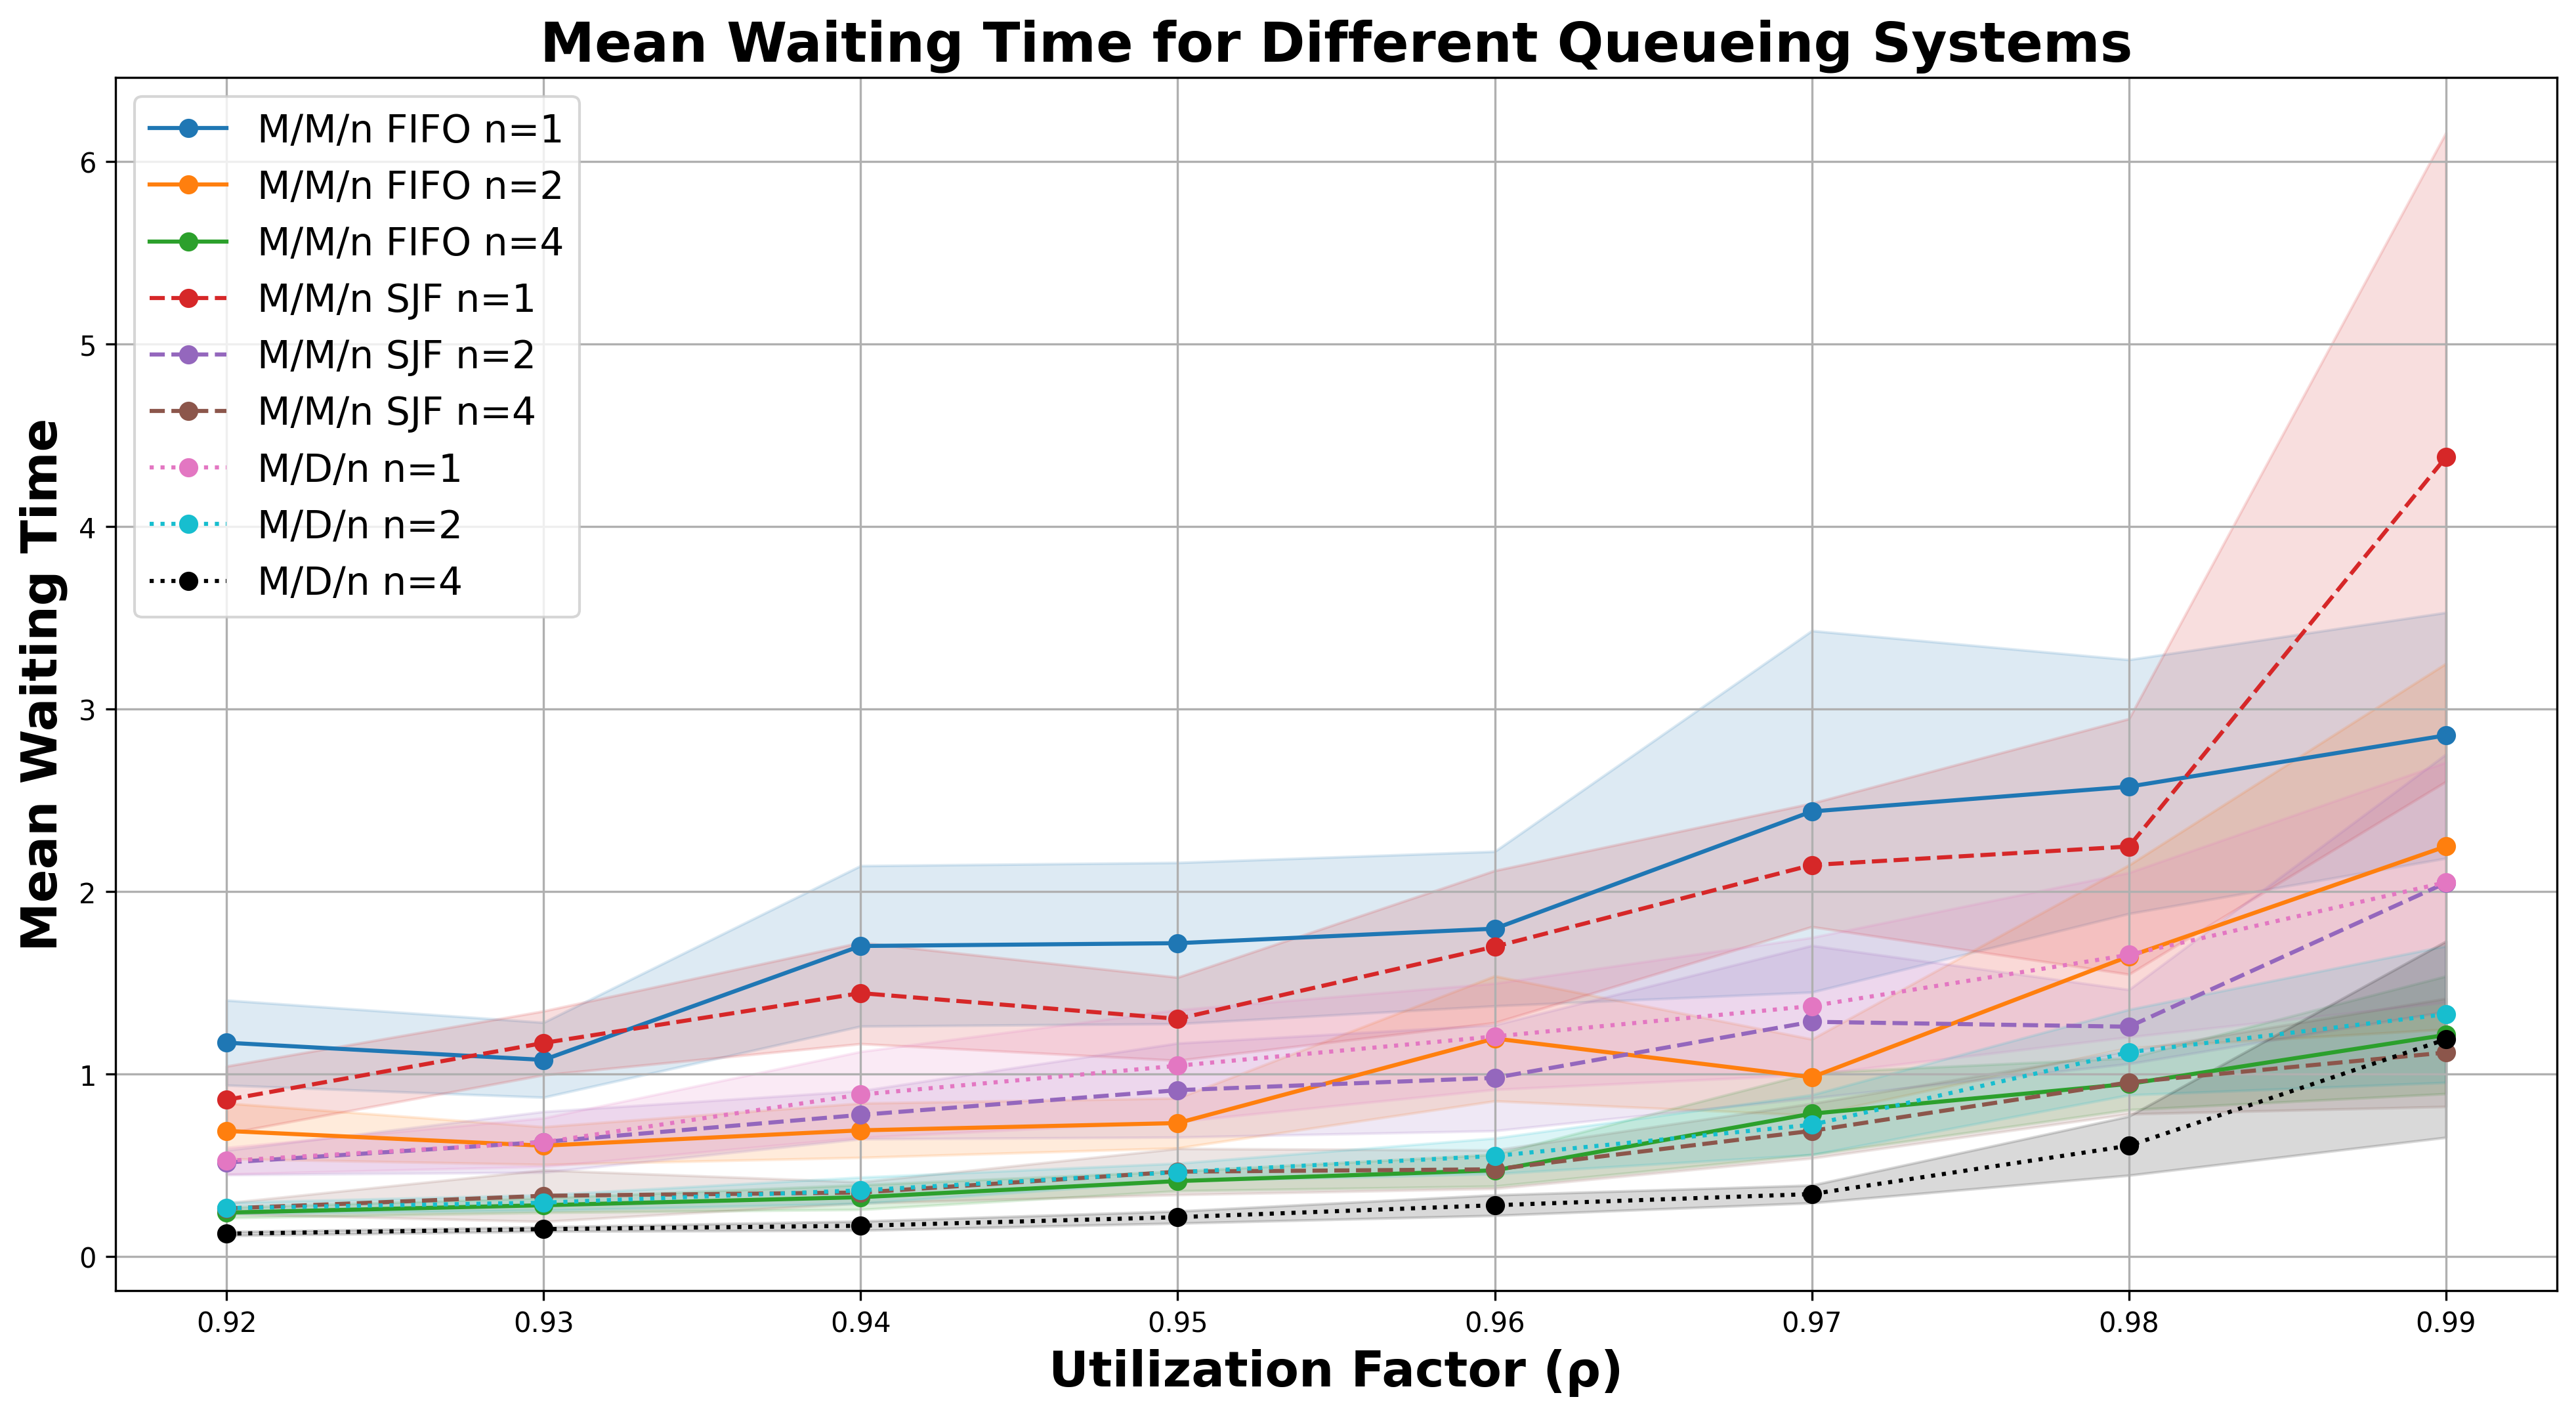

In [3]:

results_fifo, _, _= main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="M")
results_sjf, _, _ = main(NUM_SERVERS, RHO_VALUES, priority=True, service_type="M")
results_mdn, _, _ = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="D")

# Plotting results for different queueing systems
plot_results([results_fifo, results_sjf, results_mdn], "Mean Waiting Time for Different Queueing Systems", ["M/M/n FIFO", "M/M/n SJF", "M/D/n"])

# Plotting only for M/M/n FIFO --> uncomment if you want to use 
# plot_results([results_fifo], r"M/M/n: Mean Sojourn Times for varying $\rho$", ["M/M/n FIFO"])

Number of servers: 1, ρ: 0.92, Mean wait time: 0.52, CI: (0.46, 0.57), Mean sojourn time: 0.62, CI: (0.56, 0.67)
Number of servers: 1, ρ: 0.93, Mean wait time: 0.74, CI: (0.49, 0.98), Mean sojourn time: 0.84, CI: (0.59, 1.08)
Number of servers: 1, ρ: 0.9400000000000001, Mean wait time: 0.76, CI: (0.59, 0.92), Mean sojourn time: 0.86, CI: (0.69, 1.02)
Number of servers: 1, ρ: 0.9500000000000001, Mean wait time: 0.81, CI: (0.68, 0.95), Mean sojourn time: 0.91, CI: (0.78, 1.05)
Number of servers: 1, ρ: 0.96, Mean wait time: 0.96, CI: (0.71, 1.22), Mean sojourn time: 1.06, CI: (0.81, 1.32)
Number of servers: 1, ρ: 0.97, Mean wait time: 1.06, CI: (0.79, 1.33), Mean sojourn time: 1.16, CI: (0.89, 1.43)
Number of servers: 1, ρ: 0.98, Mean wait time: 1.60, CI: (1.06, 2.13), Mean sojourn time: 1.70, CI: (1.16, 2.23)
Number of servers: 1, ρ: 0.99, Mean wait time: 2.13, CI: (1.53, 2.72), Mean sojourn time: 2.23, CI: (1.63, 2.82)
Number of servers: 2, ρ: 0.92, Mean wait time: 0.28, CI: (0.24, 0.32

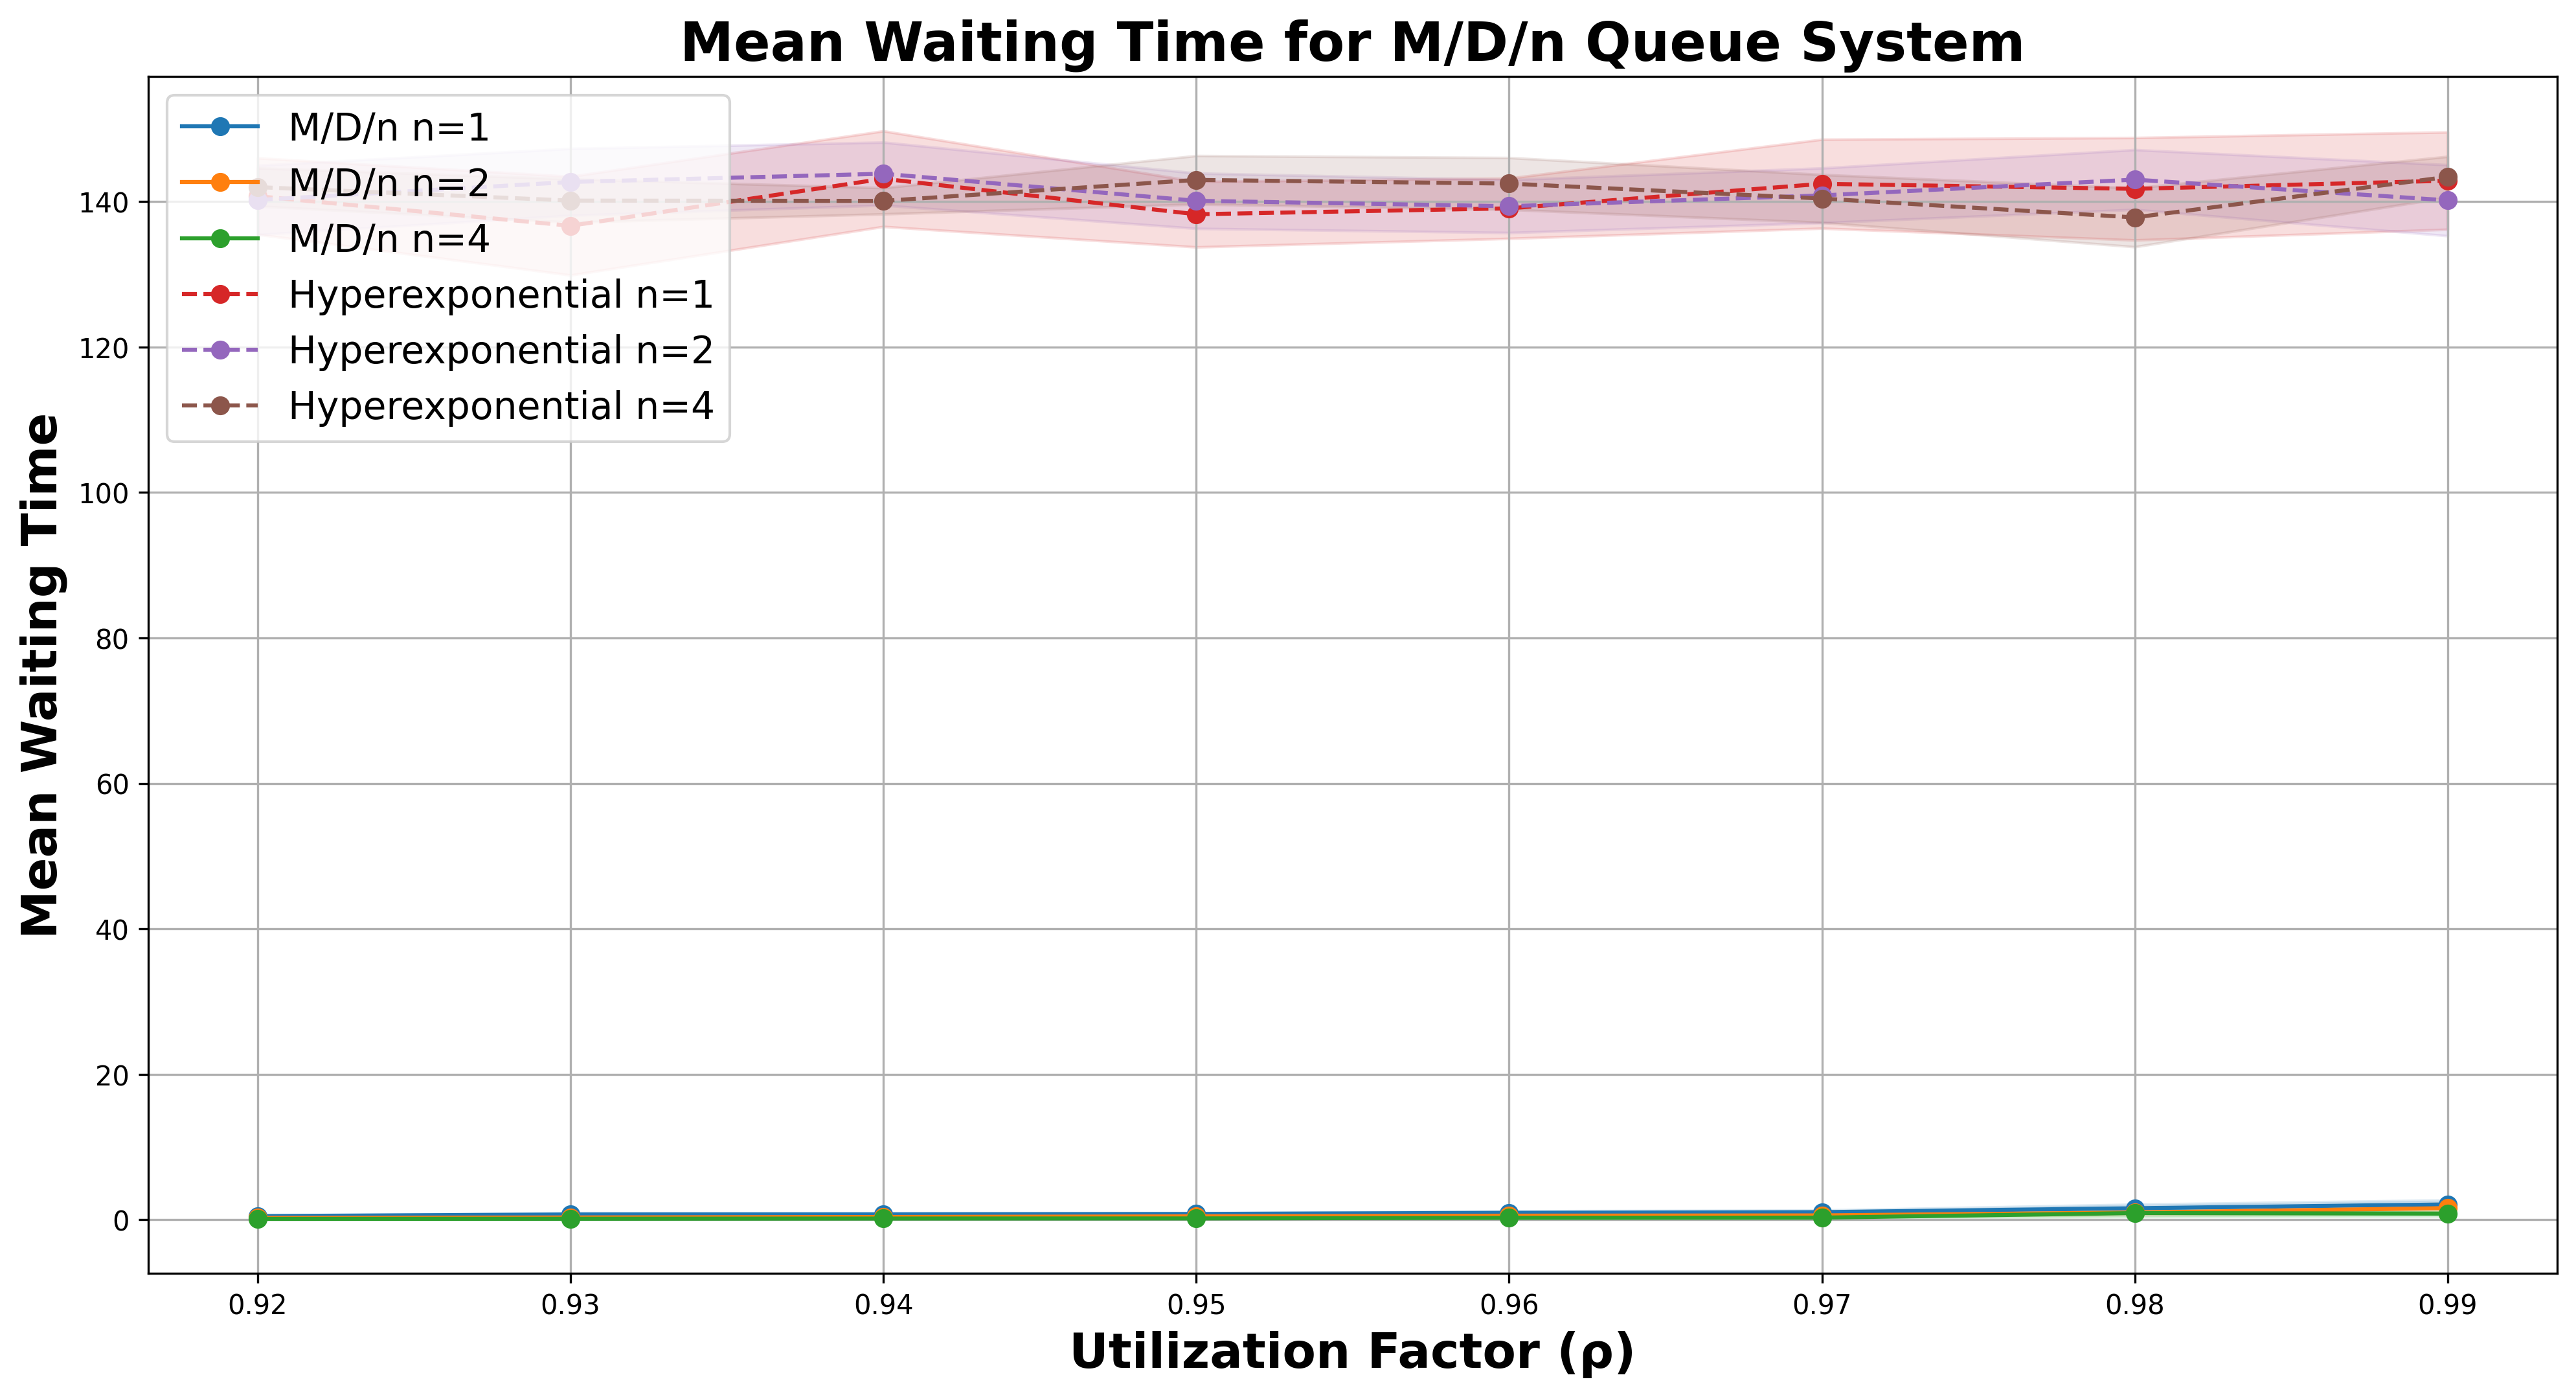

In [4]:

# Running simulations for different service rate distributions
results_mdn, _, _ = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="D")
results_hyper, _, _ = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="H")

# Plotting results for different service rate distributions
plot_results([results_mdn], "Mean Waiting Time for Deterministic Service Distribution", ["M/D/n"])
plot_results([results_hyper], "Mean Waiting Time for Long-Tail Service Distribution", [ "Hyperexponential"])


In [5]:
from scipy import stats

RHO_VALUES = [0.92, 0.96, 0.99]

results_fifo, run_mean_wait_times_fifo, _ = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="M")
results_sjf, run_mean_wait_times_sjf, _ = main(NUM_SERVERS, RHO_VALUES, priority=True, service_type="M")
results_mdn, run_mean_wait_times_mdn, _ = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="D")


results_fifo_sojourn, run_mean_sojourn_times_fifo, _ = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="M")

# Perform t-tests for each ρ value
for rho in RHO_VALUES:
    print(f"\n--- T-tests for ρ={rho} ---")

    for n_servers in NUM_SERVERS:
        # Collect all waiting times for FIFO and SJF for this ρ value and server count
    
        # Only M/M/n FIFO E(W)
        fifo_waiting_times_4 = run_mean_wait_times_fifo[4][rho]   # n=4
        fifo_waiting_times_2 = run_mean_wait_times_fifo[2][rho]   # n=2
        fifo_waiting_times_1 = run_mean_wait_times_fifo[1][rho]   # n=1

         # n=4 vs n=1 FIFO E(W)
        t_stat, p_value = stats.ttest_ind(fifo_waiting_times_4, fifo_waiting_times_1)
        print(f"Wait: Server Count 4 vs. 1, FIFO at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")

        # n=2 vs n=1 FIFO E(W)
        t_stat, p_value = stats.ttest_ind(fifo_waiting_times_2, fifo_waiting_times_1)
        print(f" Wait: Server Count 2 vs. 1, FIFO at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")

        # Only M/M/n SJF E(W)
        fifo_sojourn_times_4 = run_mean_sojourn_times_fifo[4][rho]  # n=4
        fifo_sojourn_times_2 = run_mean_sojourn_times_fifo[2][rho]  # n=2
        fifo_sojourn_times_1 = run_mean_sojourn_times_fifo[1][rho]  # n=1

        # n=4 vs n=1 FIFO E(S)
        t_stat, p_value = stats.ttest_ind(fifo_sojourn_times_4, fifo_sojourn_times_1)
        print(f" Sojourn: Server Count 4 vs. 1, FIFO at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")

        # n=2 vs n=1 FIFO E(S)
        t_stat, p_value = stats.ttest_ind(fifo_sojourn_times_2, fifo_sojourn_times_1)
        print(f" Sojourn: Server Count 2 vs. 1, FIFO at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")
        
        # Other comparisons
        fifo_waiting_times = run_mean_wait_times_fifo[n_servers][rho]
        sjf_waiting_times = run_mean_wait_times_sjf[n_servers][rho]
        mdn_waiting_times = run_mean_wait_times_mdn[n_servers][rho]
        
        # FIFO VS SJF
        t_stat, p_value = stats.ttest_ind(fifo_waiting_times, sjf_waiting_times)
        print(f"Server Count {n_servers}, FIFO vs SJF at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")
        
        # FIFO VS M/D/n
        t_stat, p_value = stats.ttest_ind(fifo_waiting_times, mdn_waiting_times)
        print(f"Server Count {n_servers}, FIFO vs MDN at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")
        
        # SJF VS M/D/n
        t_stat, p_value = stats.ttest_ind(sjf_waiting_times, mdn_waiting_times)
        print(f"Server Count {n_servers}, SJF vs MDN at ρ={rho}: T-statistic: {t_stat}, P-value: {p_value}")



Number of servers: 1, ρ: 0.92, Mean wait time: 1.24, CI: (0.90, 1.57), Mean sojourn time: 1.34, CI: (1.00, 1.67)
Number of servers: 1, ρ: 0.96, Mean wait time: 1.57, CI: (1.24, 1.91), Mean sojourn time: 1.67, CI: (1.33, 2.01)
Number of servers: 1, ρ: 0.99, Mean wait time: 3.36, CI: (2.02, 4.69), Mean sojourn time: 3.45, CI: (2.12, 4.79)
Number of servers: 2, ρ: 0.92, Mean wait time: 0.51, CI: (0.43, 0.59), Mean sojourn time: 0.61, CI: (0.53, 0.69)
Number of servers: 2, ρ: 0.96, Mean wait time: 1.12, CI: (0.75, 1.49), Mean sojourn time: 1.22, CI: (0.85, 1.60)
Number of servers: 2, ρ: 0.99, Mean wait time: 2.01, CI: (1.36, 2.66), Mean sojourn time: 2.11, CI: (1.46, 2.76)
Number of servers: 4, ρ: 0.92, Mean wait time: 0.25, CI: (0.21, 0.28), Mean sojourn time: 0.34, CI: (0.31, 0.37)
Number of servers: 4, ρ: 0.96, Mean wait time: 0.53, CI: (0.42, 0.64), Mean sojourn time: 0.63, CI: (0.52, 0.74)
Number of servers: 4, ρ: 0.99, Mean wait time: 1.07, CI: (0.83, 1.32), Mean sojourn time: 1.17, 